# Multilayer Perceptron for MNIST

## 0 Initialisation
As before, we start by importing all necessary libraries to Python. 

In [1]:
# import libraries
import torch

import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1 Multilayer Perceptron
We define the **architecture** of the Neural Net: Its number of layers, each layer's dimension. 
Here is where one would define more hyperparameters that we have not discussed yet.

The MLP is defined as a class, subordinate to the class `nn.Module` in PyTorch. We define by `fc1`, `fc2`, ... the layers of the Neural Network. First, we add the linear layers in the initialisation of the class. The activation funcitons are defined in a subroutine `forward` defining the forward propagation.

We use **two hidden layers** of size $512$ to compute the output.

One technicality: As discussed, the last layer is of size $10$. We want to add a softmax-activation function to compute the output. Here, this will be included in the loss function!

In [2]:
## Define the NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        # transform image to vector ('flatten')
        x = x.view(-1, 28 * 28)
        # add relu activation function to first layer
        x = F.relu(self.fc1(x))
        # dropout layer (p=0.2)
        # will be explained soon
        self.dropout = nn.Dropout(0.2)
        return x
    

# initialize the NN
model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


## 2 Loss function: Cross entropy

Now that the layers and (all except the last) activation functions are defined, we need to choose a **loss function**.

In [3]:
# Loss function: Cross Entropy
loss = nn.CrossEntropyLoss()

## 3 Optimization algorithm

Once the loss is defined, the last step is to define which optimization algorithm we are going to use. As before, we will choose **stochastic gradient descent** (Gradient Descent with random shuffling to avoid getting stuck in a local minimum).

In [4]:
learning_rate = .01 # Learning Rate
regularization = 0. # Does nothing. Will be discussed later.
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate,
                            weight_decay=regularization)

## 4 Dataset 

Now, we are going to load the data set. 
PyTorch implements the concept of a `data loader`: It loads a pre-formatted dataset and imports it into a form convenient for further use.

You will see that there are additional parameters `num_workers` and `batch_size` related to how your computer is handling the dataset. We will talk about Batch Size later.

All images are considered $28\times 28$ matrices, i.e. "two-(covariant)-dimensional tensors". 

In [5]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

batch_size, num_workers = 20, 4

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

We now visualize some examples of the dataset.

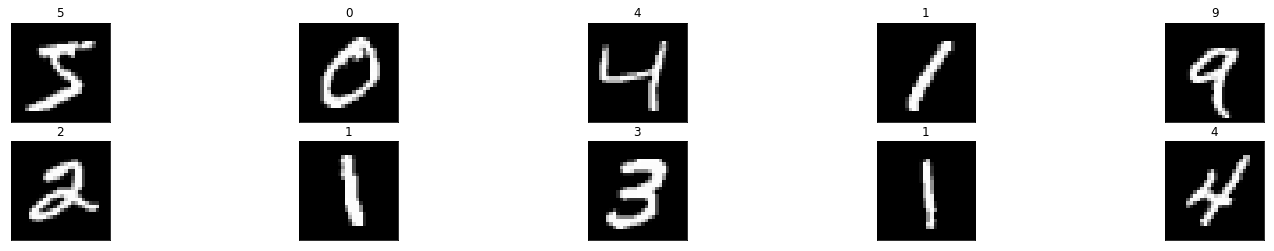

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

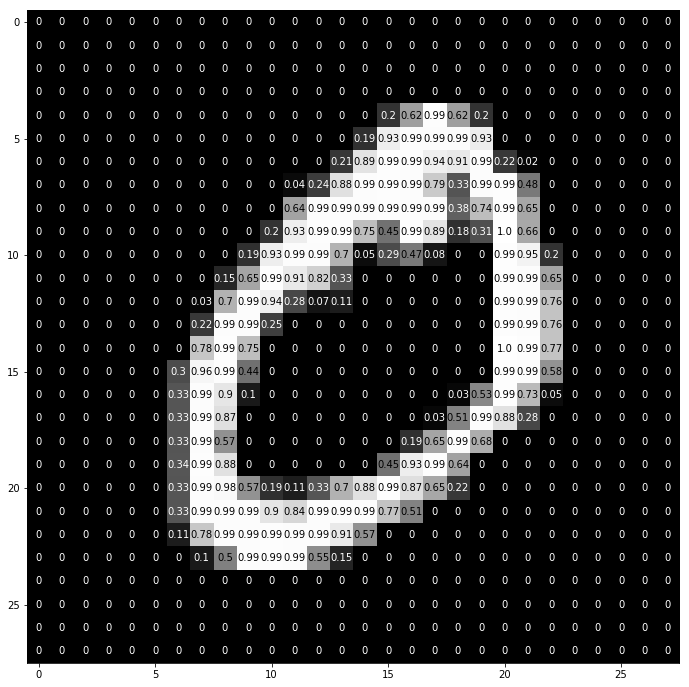

In [7]:
# select and extract next image
img = np.squeeze(images[1])

# prepare figure for plotting
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)

# plot
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5 # scale image for visibility
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## 3 Train the network
Our Neural Network is defined! Now, we need to minimize the chosen loss function to find appropriate weights. Backpropagation does not need to be programmed by hand.

We need two **for** loops: One is over the number of epochs (iterations in optimisation), another one over the data set. The `data_loader` infrastructure in PyTorch allows us to iterate over `data, target`, where `data` corresponds to an input image $x^i$ and `target` to the label $y^i\in \mathbb{R}^{10}$.

Epoch 1:  Training Loss: 0.8041813950029513
Epoch 6:  Training Loss: 0.32581778486197194
Epoch 11:  Training Loss: 0.3005355541581909
Epoch 16:  Training Loss: 0.2885525491562051
Epoch 21:  Training Loss: 0.2810988312312402


Text(0, 0.5, 'Cross-Entropy Loss')

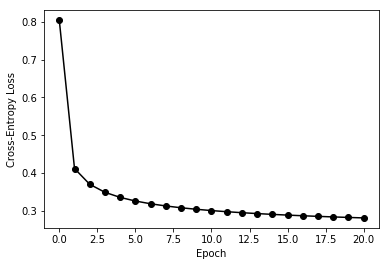

In [8]:
# define number of iterations
n_epochs = 21

# put your model into 'training mode'
model.train()

# prepare list for plotting later
losses = []

for epoch in range(n_epochs):
    total_loss = 0.
    
    for data, target in train_loader:
        # PyTorch technicality: Gradients need to be reset after each step
        optimizer.zero_grad()
        
        # Compute the output using the current parameters
        output = model(data)
        
        # calculate the loss
        new_loss = loss(output, target)
        
        # Compute Gradients using Backpropagation
        new_loss.backward()
        
        # Update your parameters according to chosen optimizer
        optimizer.step()
        
        # update training loss
        total_loss += new_loss.item()*data.size(0)
        
    total_loss /= len(train_loader.dataset)
    losses.append(total_loss)
    
    if epoch % 5==0:
        print('Epoch {}:  Training Loss: {}'.format(epoch+1, total_loss))
        
plt.plot(range(losses.__len__()), losses, 'ko-')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')

## 4 Prediction
Congratulations, you have successfully trained a Neural Network! 

You can now use the code to freely change hyperparameters, add layers, change activation functions, etc.

To visualize the prediction of our MLP, we load some images from the test set, run a prediction, and display the picture with its predicted class. 

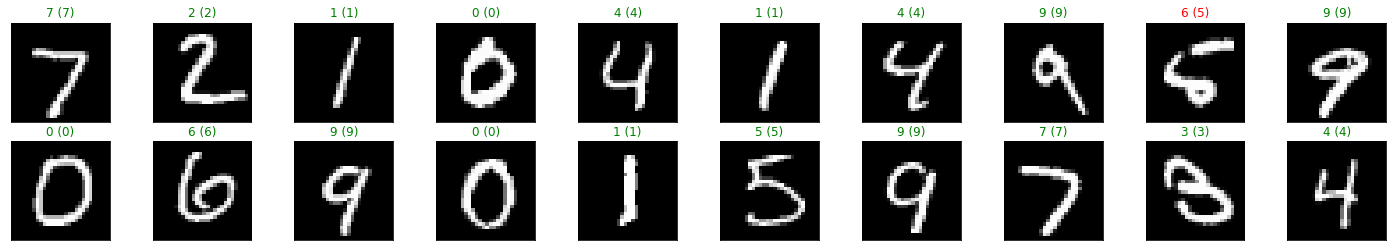

In [9]:
# obtain test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# load an image
output = model(images)
# compute predicted class from NN output
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## 5 Test the performance of the Neural Network
That does not look too bad. 

As a measure of accuracy, we compute the ratio of correct predictions per class.

In [10]:
# initialize lists
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Put the model into 'testing mode'
model.eval()

# Loop through test data
for data, target in test_loader:
    # predict
    output = model(data)
    # compute the loss
    loss_now = loss(output, target)
    # add to cumulative loss
    test_loss += loss_now.item()*data.size(0)
    # compute predicted class from NN output
    _, pred = torch.max(output, 1)
    # compare prediction to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # update test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Average Loss on dataset: {}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy for digit {}: {}% ({}/{})'.format(
            i, 
            np.round(100 * class_correct[i] / class_total[i], 1),
            int(np.sum(class_correct[i])), 
            int(np.sum(class_total[i]))))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nAverage Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Average Loss on dataset: 0.2785895747197792

Test Accuracy for digit 0: 98.1% (961/980)
Test Accuracy for digit 1: 97.6% (1108/1135)
Test Accuracy for digit 2: 88.7% (915/1032)
Test Accuracy for digit 3: 90.7% (916/1010)
Test Accuracy for digit 4: 92.7% (910/982)
Test Accuracy for digit 5: 87.3% (779/892)
Test Accuracy for digit 6: 95.1% (911/958)
Test Accuracy for digit 7: 91.6% (942/1028)
Test Accuracy for digit 8: 88.4% (861/974)
Test Accuracy for digit 9: 90.5% (913/1009)

Average Accuracy (Overall): 92% (9216/10000)


Congratulations! The Neural Network attains a testset accuracy of $0.92$. Since human performance is estimated to lie between $0.98$ and $0.99$, this is not a good performance result in 2019.

Different Neural Networks attain **super-human** performance on this standard dataset. Accuracies of $0.995$ are regularly attained.